In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.feature_selection import RFECV

In [2]:
data = pd.read_csv('flights_50000', index_col=0)

In [67]:
def drop_and_fill_na(data):
    '''This function drops undesired columns and fills Nans with 0
    it also removes cancelled flights and flights that do not have a tail number'''
    #categorical columns that we will replace null values with 0
    columns = ['dep_delay', 'tail_num', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time']
    
    df = data.copy()
    
    #Drop rows that are cancelled flights
    df[((df.cancelled != 'A') & (df.cancelled != 'B') & (df.cancelled != 'C'))]
    
    
    #Drop columns that are unnecessary
    df.drop(['actual_elapsed_time', 'diverted', 'dep_time', 'taxi_out', 'taxi_in', 'arr_time', 'arr_delay', 'air_time', 'cancelled', 'cancellation_code', 'op_unique_carrier', 'wheels_off', 'wheels_on', 'no_name', 'total_add_gtime', 'longest_add_gtime'], axis=1, inplace=True)
    
    #fill categorial null values with 0
    for i in columns:
        df[i].fillna(0, inplace=True)

    #Drop rows in tail_num that are null
    df[((df.tail_num != 0))]
    
    #Create a new column that marks each row as delayed or not delayed
    df['is_delayed'] = df['dep_delay'] >=1
    
    return(df)


In [75]:
df = drop_and_fill_na(data)

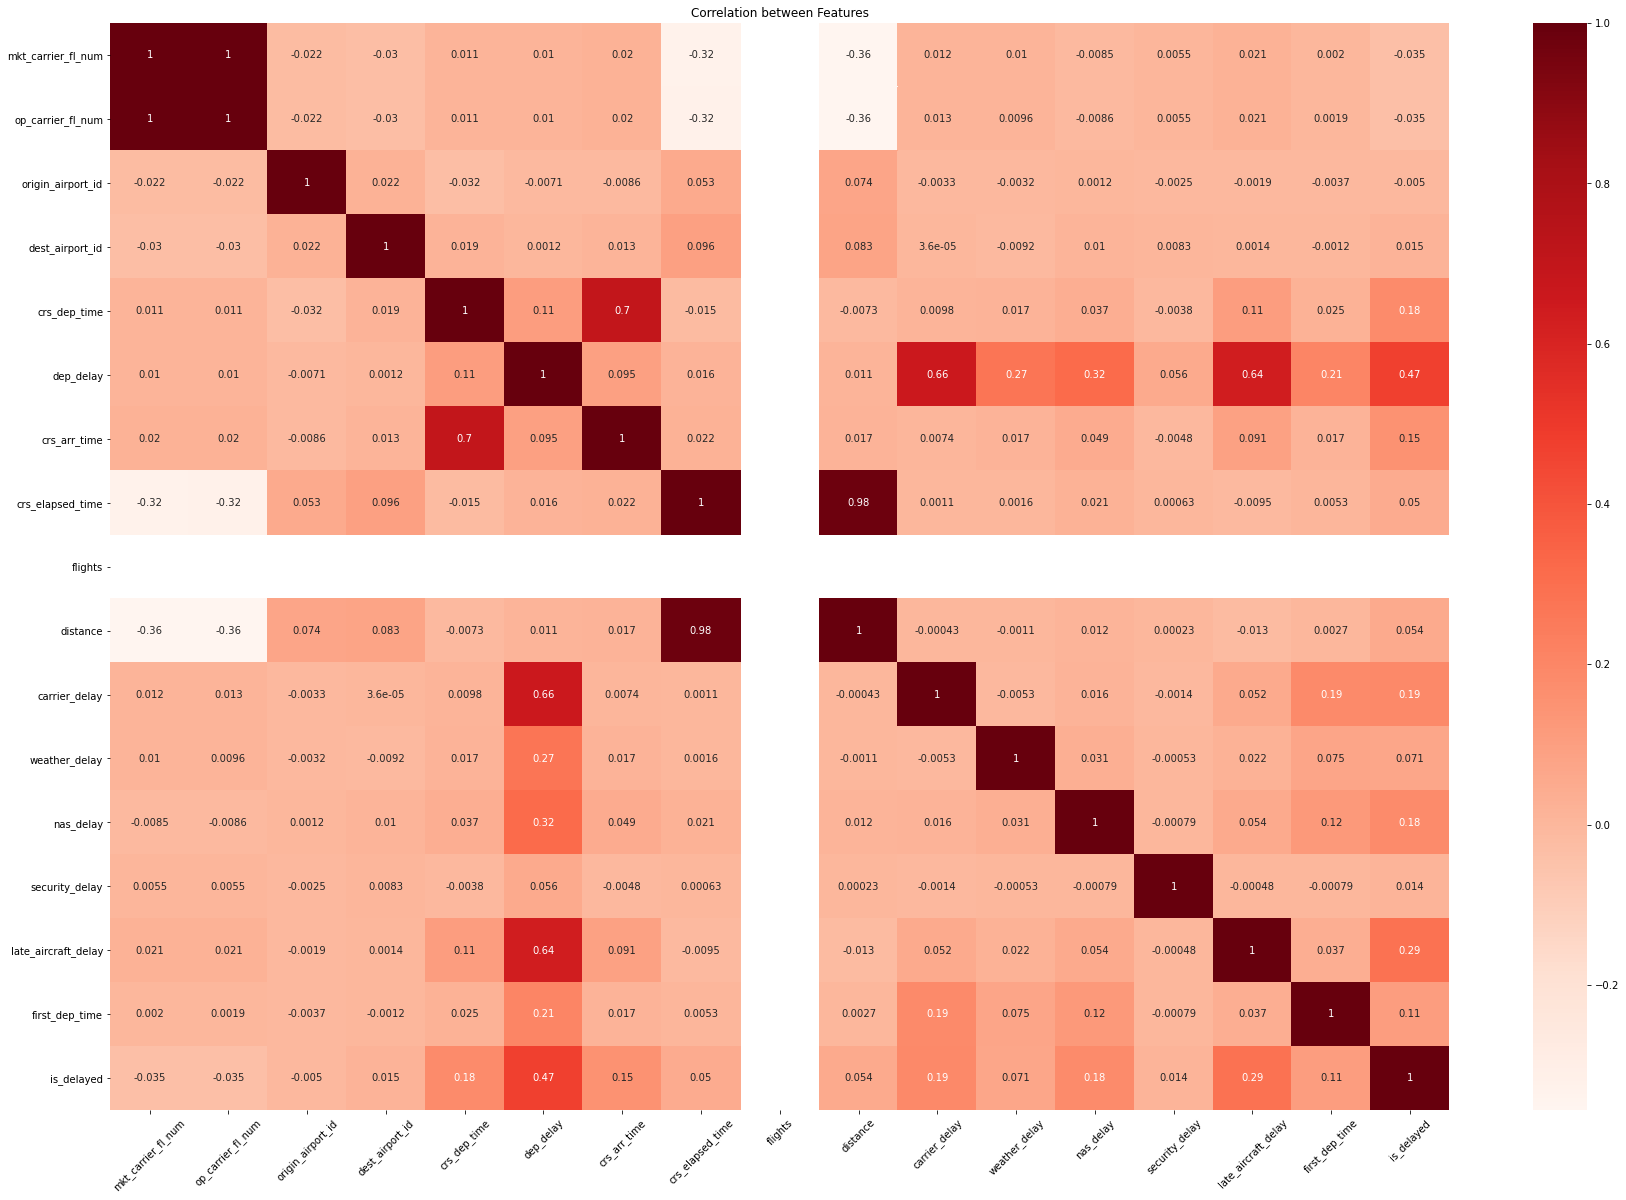

In [76]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=45)
plt.title('Correlation between Features')
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

#Note how flights has 0 correlation with anything. Only reason I left it in is because it is part of the testing sample

In [77]:
#Turns categorical data into numerical values. I decided not to Hot Encode it as that would result in hundreds of new columns. 

df['dest'] = df['dest'].astype('category')
df['dest'] = df['dest'].cat.codes

df['dest_city_name'] = df['dest_city_name'].astype('category')
df['dest_city_name'] = df['dest_city_name'].cat.codes

df['dup'] = df['dup'].astype('category')
df['dup'] = df['dup'].cat.codes

df['mkt_unique_carrier'] = df['mkt_unique_carrier'].astype('category')
df['mkt_unique_carrier'] = df['mkt_unique_carrier'].cat.codes

df['branded_code_share'] = df['branded_code_share'].astype('category')
df['branded_code_share'] = df['branded_code_share'].cat.codes

df['mkt_carrier'] = df['mkt_carrier'].astype('category')
df['mkt_carrier'] = df['mkt_carrier'].cat.codes

df['tail_num'] = df['tail_num'].astype('category')
df['tail_num'] = df['tail_num'].cat.codes

df['origin'] = df['origin'].astype('category')
df['origin'] = df['origin'].cat.codes

df['origin_city_name'] = df['origin_city_name'].astype('category')
df['origin_city_name'] = df['origin_city_name'].cat.codes

df['origin_city_name'] = df['origin_city_name'].astype('category')
df['origin_city_name'] = df['origin_city_name'].cat.codes

df['is_delayed'] = df['is_delayed'].astype('category')
df['is_delayed'] = df['is_delayed'].cat.codes

df.drop(['fl_date', 'dup', 'flights'], axis = 1, inplace=True) #These columns are 0 after normalizing

In [71]:
X =  df.drop(["is_delayed"], axis = 1)
y = df['is_delayed']

#normalize X
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

C:\Users\Peter\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Peter\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Optimal number of features: 17


C:\Users\Peter\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


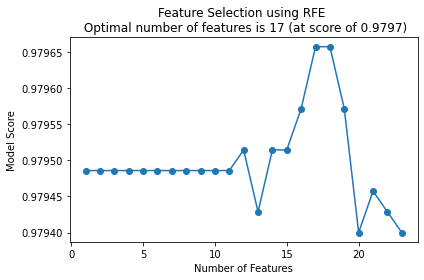

In [80]:
#Feature selection
clf = LogisticRegression(random_state = 42) 

#cross validation and recursive feature selection
feature_selector = RFECV(clf)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

df_X_train = pd.DataFrame(X_train)
df_X_train = df_X_train.loc[:, feature_selector.get_support()]

df_X_test  = pd.DataFrame(X_test)
df_X_test  = df_X_test.loc[:, feature_selector.get_support()]

plt.plot(range(1,len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_),4)})" )
plt.tight_layout()
plt.show()